In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.style.use("dark_background")

from sklearn.linear_model import Ridge

from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
# scaler = MinMaxScaler(feature_range=(-1,1))

In [2]:
diri = '/work/bb0983/athul_satheesh/e_obs_precip/'
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/figures/'

coarse_raw = 'rr_ens_mean_1.0deg_reg_v29.0e.nc'
fine_raw = 'rr_ens_mean_0.1deg_reg_v29.0e.nc'

lati = 43#40
latf = 59#60

loni = -6#-10
lonf = 15#30

strt = '1950-01-01'
last = '2023-12-31'

coarse_data = xr.open_dataset(diri+coarse_raw).rr.transpose('time','lat','lon').sel(time=slice(strt, last), 
                                                                                    lat=slice(lati, latf), 
                                                                                    lon=slice(loni, lonf))
fine_data = xr.open_dataset(diri+fine_raw).rr.transpose('time','latitude','longitude').sel(time=slice(strt, last), 
                                                                                           latitude=slice(lati, latf), 
                                                                                           longitude=slice(loni, lonf))
fine_data = fine_data.rename({'latitude':'lat', 'longitude':'lon'})

In [3]:
dims_coarse = coarse_data.shape
dims_fine = fine_data.shape

In [4]:
dims_coarse, dims_fine

((27028, 16, 21), (27028, 160, 210))

In [5]:
train_strt = strt
train_last = '2000-12-31'

test_strt = '2001-01-01'
test_last = last

coarse_data_train = coarse_data.sel(time=slice(train_strt, train_last))#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_train = coarse_data_train.fillna(coarse_data_train.mean())
coarse_data_test = coarse_data.sel(time=slice(test_strt, test_last))#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_test = coarse_data_test.fillna(coarse_data_test.mean())
# print(coarse_data_train.shape, coarse_data_test.shape)

fine_data_train = fine_data.sel(time=slice(train_strt, train_last))
fine_data_test = fine_data.sel(time=slice(test_strt, test_last))
# print(fine_data_train.shape, fine_data_test.shape)

In [6]:
coarse_nan_mask = np.isnan(coarse_data_test)
fine_nan_mask = np.isnan(fine_data_test)

fill_val = -1e-10

In [7]:
coarse_data_train = coarse_data_train.fillna(fill_val)#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_train = coarse_data_train.fillna(coarse_data_train.mean())
coarse_data_test = coarse_data_test.fillna(fill_val)#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_test = coarse_data_test.fillna(coarse_data_test.mean())
# print(coarse_data_train.shape, coarse_data_test.shape)

fine_data_train = fine_data_train.fillna(fill_val)
fine_data_test = fine_data_test.fillna(fill_val)
# print(fine_data_train.shape, fine_data_test.shape)

In [8]:
fine_data_test.shape

(8400, 160, 210)

In [9]:
model = Ridge(alpha=1.0, random_state=42)

In [10]:
def issue_preds(model, coarse_data_train, fine_data_train, coarse_data_test, fine_data_test):
    
    coarse_data_train = normalize_data(coarse_data_train, scaler)
    coarse_data_test = normalize_data(coarse_data_test, scaler, train=False)
    
    fine_data_train = normalize_data(fine_data_train, scaler)
    fine_data_test = normalize_data(fine_data_test, scaler, train=False)
    
    history = model.fit(coarse_data_train, fine_data_train)
    pred = model.predict(coarse_data_test)  
    
    return pred

In [11]:
def normalize_data(dataset, scaler, train=True):
    
    dims = dataset.shape
    # print(dims)
    
    dataset = dataset.values.reshape(-1, dims[1]*dims[2])

    if train:
        normalized_data = scaler.fit_transform(dataset)
    else:
        normalized_data = scaler.transform(dataset)
        
    return normalized_data

In [12]:
%%time
preds = issue_preds(model, coarse_data_train, fine_data_train, coarse_data_test, fine_data_test).reshape(fine_data_test.shape)
# del model

CPU times: user 1min 30s, sys: 25.1 s, total: 1min 55s
Wall time: 5.33 s


In [13]:
def inverse_normalize_data(normalized_data, scaler):
    
    dims = normalized_data.shape
    
    normalized_data = normalized_data.reshape(-1, dims[1]*dims[2])
    
    original_data = scaler.inverse_transform(normalized_data)
    
    return original_data

In [14]:
downscaled_data = inverse_normalize_data(preds, scaler).reshape(fine_data_test.shape)

In [15]:
downscaled_data.shape

(8400, 160, 210)

In [16]:
downscaled_data = xr.DataArray(name='precipitation', data=downscaled_data, dims=fine_data_test.dims, coords=fine_data_test.coords, attrs=fine_data_test.attrs)

In [17]:
# downscaled_data = xr.where(downscaled_data>=0, downscaled_data, np.nan)
# fine_data_test = xr.where(fine_data_test>=0, fine_data_test, np.nan)
# coarse_data_test = xr.where(coarse_data_test>=0, coarse_data_test, np.nan)

downscaled_data = downscaled_data.where(~fine_nan_mask, np.nan)
fine_data_test = fine_data_test.where(~fine_nan_mask, np.nan)
coarse_data_test = coarse_data_test.where(~coarse_nan_mask, np.nan)

In [24]:
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/downscaled_data/'
downscaled_data.to_netcdf(diro + 'e_obs_eu_downscaled_ridge.nc')

In [19]:
date1 = '2014-06-09'
date2 = '2014-06-09'

print(f"MAE: {abs(fine_data_test - downscaled_data).mean().values:.4f}")
print(f"RMSE: {np.sqrt( ( (fine_data_test - downscaled_data)**2 ).mean() ).values:.4f}")

MAE: 1.0792
RMSE: 2.4739


In [20]:
# np.corrcoef(fine_data_test.values.flatten(), downscaled_data.values.flatten())[0,1]

In [21]:
from sklearn.metrics import r2_score
def compute_r2_with_nans(y_true, y_pred):
    # Mask for non-NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    # Filter out NaN values
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Compute R2 score
    r2 = r2_score(y_true_filtered, y_pred_filtered)
    return r2
r2 = compute_r2_with_nans(fine_data_test.values.flatten(), downscaled_data.values.flatten())
r2

0.7818455237729636

In [22]:
# figs, axx = plt.subplots(figsize=(8,6))
# axx.scatter(fine_data_test.values.flatten(), downscaled_data.values.flatten(), s=1.5, alpha=0.9, color='C0')
# axx.plot([0,1000], [0,1000], color='red', alpha=0.9, zorder=1, ls='--')
# axx.set_xlim(-8,300)
# axx.set_ylim(-8,300)
# axx.set_xlabel('Observation', size=15)
# axx.set_ylabel('Downscaled', size=15)
# axx.text(45,250,f'$R^2: {r2:.2f}$', color='white', size=12)
# axx.grid(True, alpha=0.2, color='C1')

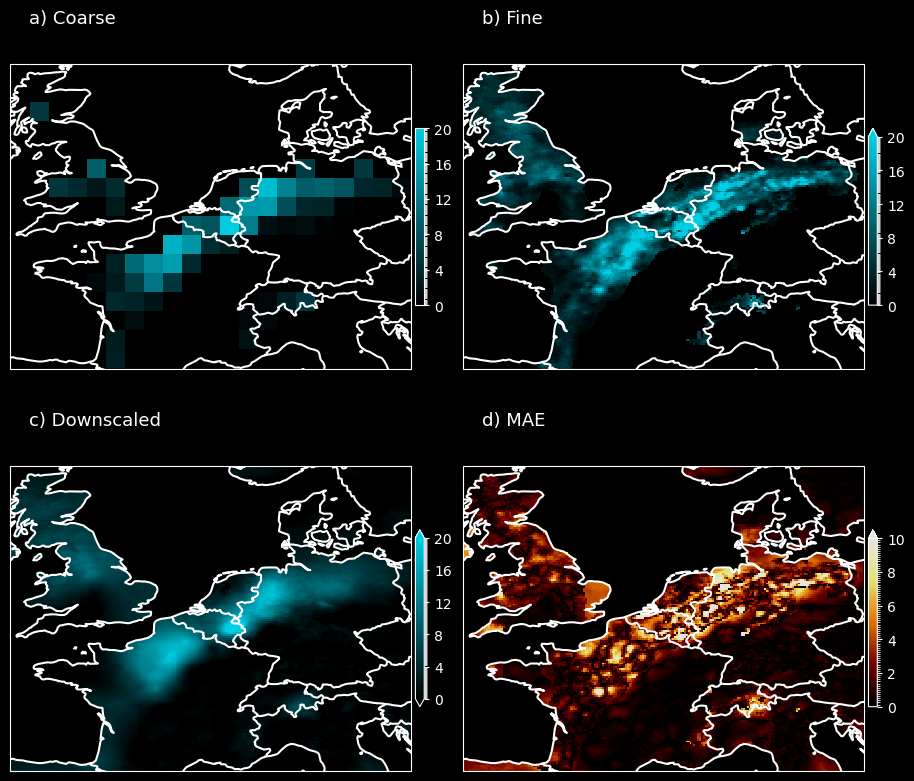

In [23]:
# Define the colormap colors
colors_blues2black = [(0, 0, 0), (0, 0.90, 1)]  # Blue to Black
colors_RdBlBu = [(1, 0, 0), (0, 0, 0), (0, 0.90, 1)]  # Blue to Black

# Create the colormap
cmap_name = 'BluesToBlack'
blues_to_black = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_blues2black)
Rd_bl_Bu = mcolors.LinearSegmentedColormap.from_list('RdBlBu', colors_RdBlBu)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10), sharex=True, sharey=True,
                        subplot_kw=dict(projection=ccrs.PlateCarree(), facecolor='black'),
                        gridspec_kw={'wspace': -0.05, 'hspace': 0.09})

# plots = [coarse_data_test, fine_data_test, downscaled_data, (fine_data_test - downscaled_data)]
plots = [coarse_data_test, fine_data_test, downscaled_data, abs(fine_data_test - downscaled_data)]
cmap = [blues_to_black, blues_to_black, blues_to_black, 'afmhot']
# cmap = [blues_to_black, blues_to_black, blues_to_black, Rd_bl_Bu]
# levels = [np.arange(0,30.25,0.25), np.arange(0,30.25,0.25), np.arange(0,30.25,0.25), np.arange(-12,12.25,0.25)]
levels = [np.arange(0,20.125,0.125), np.arange(0,20.125,0.125), np.arange(0,20.125,0.125), np.arange(0,10.125,0.125)]
# title = ['a) Coarse','b) Fine','c) Downscaled','d) Observed-Downscaled']
title = ['a) Coarse','b) Fine','c) Downscaled','d) MAE']
# ticks = [np.arange(0,33,3), np.arange(0,33,3), np.arange(0,33,3), np.arange(-12,13,4)]
ticks = [np.arange(0,24,4), np.arange(0,24,4), np.arange(0,24,4), np.arange(0,12,2)]

for i, ax in enumerate(axs.flatten()):
    plots[i].sel(time=slice(date1, date2)).mean('time').plot(cmap=cmap[i], levels=levels[i], 
                                                             ax=ax, cbar_kwargs={'orientation':'vertical',
                                                                                'pad':0.01, 'label':'',
                                                                                'shrink':0.48, 'drawedges':False,
                                                                                'ticks': ticks[i], },
                                                            alpha=0.90)
    
    ax.text(-5, 61.2, f'{title[i]}',size=13, color='white')
    ax.coastlines(linewidth=1.5, color='white')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.5, edgecolor='white');
    ax.patch.set_facecolor('black')
plt.show()